In [2]:
import os, glob
import json
import folium
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from keras.models import Sequential
from keras.layers import LSTM, Dense
import warnings
warnings.filterwarnings("ignore")

#### Preprocessing

In [3]:
PATH_DATASET = "D:/MyCode/ML2 project/predict-energy-behavior-of-prosumers"

forecast_weather  = pd.read_csv(os. path.join(PATH_DATASET, f"forecast_weather.csv"))
forecast_weather ['origin_datetime'] = pd.to_datetime(forecast_weather ['origin_datetime'])
forecast_weather ['forecast_datetime'] = pd.to_datetime(forecast_weather ['forecast_datetime'])
print(f"forecast size: {len(forecast_weather )}")

display(forecast_weather .head())

forecast size: 3424512


,latitude,longitude,origin_datetime,hours_ahead,temperature,dewpoint,cloudcover_high,cloudcover_low,cloudcover_mid,cloudcover_total,10_metre_u_wind_component,10_metre_v_wind_component,data_block_id,forecast_datetime,direct_solar_radiation,surface_solar_radiation_downwards,snowfall,total_precipitation
0,57.6,21.7,2021-09-01 00:00:00+00:00,1,15.655786,11.553613,0.904816,0.019714,0.000000,0.905899,-0.411328,-9.106137,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
1,57.6,22.2,2021-09-01 00:00:00+00:00,1,13.003931,10.689844,0.886322,0.004456,0.000000,0.886658,0.206347,-5.355405,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
2,57.6,22.7,2021-09-01 00:00:00+00:00,1,14.206567,11.671777,0.729034,0.005615,0.000000,0.730499,1.451587,-7.417905,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
3,57.6,23.2,2021-09-01 00:00:00+00:00,1,14.844507,12.264917,0.336304,0.074341,0.000626,0.385468,1.090869,-9.163999,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0
4,57.6,23.7,2021-09-01 00:00:00+00:00,1,15.293848,12.458887,0.102875,0.088074,0.000015,0.176590,1.268481,-8.975766,1,2021-09-01 01:00:00+00:00,0.0,0.0,0.0,0.0


In [4]:
historical_weather = pd.read_csv(os. path.join(PATH_DATASET, f"historical_weather.csv"))
historical_weather ['datetime'] = pd.to_datetime(historical_weather ['datetime'])
print(f"histirical size: {len(historical_weather )}")

display(historical_weather .head())

histirical size: 1710800


,datetime,temperature,dewpoint,rain,snowfall,surface_pressure,cloudcover_total,cloudcover_low,cloudcover_mid,cloudcover_high,windspeed_10m,winddirection_10m,shortwave_radiation,direct_solar_radiation,diffuse_radiation,latitude,longitude,data_block_id
0,2021-09-01,14.4,12.0,0.0,0.0,1015.8,4,4,0,0,6.694444,3,0.0,0.0,0.0,57.6,21.7,1
1,2021-09-01,14.0,12.0,0.0,0.0,1010.6,7,8,0,0,4.944444,353,0.0,0.0,0.0,57.6,22.2,1
2,2021-09-01,14.4,12.8,0.0,0.0,1014.9,6,7,0,0,5.833333,348,0.0,0.0,0.0,57.6,22.7,1
3,2021-09-01,15.4,13.0,0.0,0.0,1014.4,4,2,4,0,7.111111,349,0.0,0.0,0.0,57.6,23.2,1
4,2021-09-01,15.9,12.6,0.0,0.0,1013.8,12,7,0,20,8.388889,360,0.0,0.0,0.0,57.6,23.7,1


In [5]:
train = pd.read_csv(os. path.join(PATH_DATASET,f'train.csv'))
gas_prices = pd.read_csv(os. path.join(PATH_DATASET,f'gas_prices.csv'))
client = pd.read_csv(os. path.join(PATH_DATASET,f'client.csv'))
electricity_prices = pd.read_csv(os. path.join(PATH_DATASET,f'electricity_prices.csv'))
location = (pd.read_csv(os. path.join(PATH_DATASET,f'county_lon_lats.csv'))
            .drop(columns = ["Unnamed: 0"])
           )

In [7]:
class FeatureProcessorClass():
    def __init__(self):         
        # Columns to join on for the different datasets
        self.weather_join = ['datetime', 'county', 'data_block_id']
        self.gas_join = ['data_block_id']
        self.electricity_join = ['datetime', 'data_block_id']
        self.client_join = ['county', 'is_business', 'product_type', 'data_block_id']
        
        # Columns of latitude & longitude
        self.lat_lon_columns = ['latitude', 'longitude']
        
        # Aggregate stats 
        self.agg_stats = ['mean'] #, 'min', 'max', 'std', 'median']
        
        # Categorical columns (specify for XGBoost)
        self.category_columns = ['county', 'is_business', 'product_type', 'is_consumption', 'data_block_id']

    def create_new_column_names(self, df, suffix, columns_no_change):
        '''Change column names by given suffix, keep columns_no_change, and return back the data'''
        df.columns = [col + suffix 
                      if col not in columns_no_change
                      else col
                      for col in df.columns
                      ]
        return df 

    def flatten_multi_index_columns(self, df):
        df.columns = ['_'.join([col for col in multi_col if len(col)>0]) 
                      for multi_col in df.columns]
        return df
    
    def create_data_features(self, data):
        '''Create features for main data (test or train) set'''
     # To datetime
        data['datetime'] = pd.to_datetime(data['datetime'])

        # Time period features
        data['date'] = data['datetime'].dt.normalize()
        data['year'] = data['datetime'].dt.year
        data['quarter'] = data['datetime'].dt.quarter
        data['month'] = data['datetime'].dt.month
        data['week'] = data['datetime'].dt.isocalendar().week.astype(int)  # Convert to integer
        data['hour'] = data['datetime'].dt.hour

        # Day features
        data['day_of_year'] = data['datetime'].dt.day_of_year
        data['day_of_month'] = data['datetime'].dt.day
        data['day_of_week'] = data['datetime'].dt.day_of_week

        return data

    def create_client_features(self, client):
        '''💼 Create client features 💼'''
        # Modify column names - specify suffix
        client = self.create_new_column_names(client, 
                                           suffix='_client',
                                           columns_no_change = self.client_join
                                          )       
        return client
    
    def create_historical_weather_features(self, historical_weather):
        '''Create historical weather features '''
        
        # To datetime
        historical_weather['datetime'] = pd.to_datetime(historical_weather['datetime'])
        
        # Add county
        historical_weather[self.lat_lon_columns] = historical_weather[self.lat_lon_columns].astype(float).round(1)
        historical_weather = historical_weather.merge(location, how = 'left', on = self.lat_lon_columns)

        # Modify column names - specify suffix
        historical_weather = self.create_new_column_names(historical_weather,
                                                          suffix='_h',
                                                          columns_no_change = self.lat_lon_columns + self.weather_join
                                                          ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in historical_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        historical_weather = historical_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        historical_weather = self.flatten_multi_index_columns(historical_weather) 
        
        # Test set has 1 day offset for hour<11 and 2 day offset for hour>11
        historical_weather['hour_h'] = historical_weather['datetime'].dt.hour
        historical_weather['datetime'] = (historical_weather
                                               .apply(lambda x: 
                                                      x['datetime'] + pd.DateOffset(1) 
                                                      if x['hour_h']< 11 
                                                      else x['datetime'] + pd.DateOffset(2),
                                                      axis=1)
                                              )
        
        return historical_weather
    
    def create_forecast_weather_features(self, forecast_weather):
        '''Create forecast weather features'''
        
        # Rename column and drop
        forecast_weather = (forecast_weather
                            .rename(columns = {'forecast_datetime': 'datetime'})
                            .drop(columns = 'origin_datetime') # not needed
                           )
        
        # To datetime
        forecast_weather['datetime'] = (pd.to_datetime(forecast_weather['datetime'])
                                        .dt
                                        .tz_convert('Europe/Brussels') # change to different time zone?
                                        .dt
                                        .tz_localize(None)
                                       )

        # Add county
        forecast_weather[self.lat_lon_columns] = forecast_weather[self.lat_lon_columns].astype(float).round(1)
        forecast_weather = forecast_weather.merge(location, how = 'left', on = self.lat_lon_columns)
        
        # Modify column names - specify suffix
        forecast_weather = self.create_new_column_names(forecast_weather,
                                                        suffix='_f',
                                                        columns_no_change = self.lat_lon_columns + self.weather_join
                                                        ) 
        
        # Group by & calculate aggregate stats 
        agg_columns = [col for col in forecast_weather.columns if col not in self.lat_lon_columns + self.weather_join]
        agg_dict = {agg_col: self.agg_stats for agg_col in agg_columns}
        forecast_weather = forecast_weather.groupby(self.weather_join).agg(agg_dict).reset_index() 
        
        # Flatten the multi column aggregates
        forecast_weather = self.flatten_multi_index_columns(forecast_weather)     
        return forecast_weather

    def create_electricity_features(self, electricity):
        '''Create electricity prices features'''
        # To datetime
        electricity['forecast_date'] = pd.to_datetime(electricity['forecast_date'])
        
        # Test set has 1 day offset
        electricity['datetime'] = electricity['forecast_date'] + pd.DateOffset(1)
        
        # Modify column names - specify suffix
        electricity = self.create_new_column_names(electricity, 
                                                   suffix='_electricity',
                                                   columns_no_change = self.electricity_join
                                                  )             
        return electricity

    def create_gas_features(self, gas):
        '''Create gas prices features'''
        # Mean gas price
        gas['mean_price_per_mwh'] = (gas['lowest_price_per_mwh'] + gas['highest_price_per_mwh'])/2
        
        # Modify column names - specify suffix
        gas = self.create_new_column_names(gas, 
                                           suffix='_gas',
                                           columns_no_change = self.gas_join
                                          )       
        return gas
    
    def __call__(self, data, client, historical_weather, forecast_weather, electricity, gas):
        '''Processing of features from all datasets, merge together and return features for dataframe df '''
        # Create features for relevant dataset
        data = self.create_data_features(data)
        client = self.create_client_features(client)
        historical_weather = self.create_historical_weather_features(historical_weather)
        forecast_weather = self.create_forecast_weather_features(forecast_weather)
        electricity = self.create_electricity_features(electricity)
        gas = self.create_gas_features(gas)
        
        # Merge all datasets into one df 
        df = data.merge(client, how='left', on = self.client_join)
        df = df.merge(historical_weather, how='left', on = self.weather_join)
        df = df.merge(forecast_weather, how='left', on = self.weather_join)
        df = df.merge(electricity, how='left', on = self.electricity_join)
        df = df.merge(gas, how='left', on = self.gas_join)
        
        # Change columns to categorical for XGBoost
        df[self.category_columns] = df[self.category_columns].astype('category')
        return df

In [9]:
FeatureProcessor=FeatureProcessorClass()
#create df
df_with_target = FeatureProcessor(data = train.copy(),
                      client = client.copy(),
                      historical_weather = historical_weather.copy(),
                      forecast_weather = forecast_weather.copy(),
                      electricity = electricity_prices.copy(),
                      gas = gas_prices.copy(),
                     )

target = 'target' #extract target variable
df = df_with_target[df_with_target[target].notnull()].reset_index(drop=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2017824 entries, 0 to 2017823
Data columns (total 57 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   county                                    category      
 1   is_business                               category      
 2   product_type                              category      
 3   target                                    float64       
 4   is_consumption                            category      
 5   datetime                                  datetime64[ns]
 6   data_block_id                             category      
 7   row_id                                    int64         
 8   prediction_unit_id                        int64         
 9   date                                      datetime64[ns]
 10  year                                      int32         
 11  quarter                                   int32         
 12  month         

In [12]:
if 'row_id' in df.columns:
    df = df.drop(['row_id'], axis=1)
if 'datetime' in df.columns:
    df = df.drop(['datetime'], axis=1)
if 'date' in df.columns:
    df = df.drop(['date'], axis=1)
if 'prediction_unit_id' in df.columns:
    df = df.drop(['prediction_unit_id'], axis=1)

df.head()

,county,is_business,product_type,target,is_consumption,data_block_id,year,quarter,month,week,...,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas
0,0,0,1,0.713,0,0,2021,3,9,35,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,1,96.590,1,0,2021,3,9,35,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,2,0.000,0,0,2021,3,9,35,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,2,17.314,1,0,2021,3,9,35,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,3,2.904,0,0,2021,3,9,35,...,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
# Select numeric type columns for interpolation
numeric_df = df.select_dtypes(include=[np.number])
numeric_df_interpolated = numeric_df.interpolate()

# Merge interpolated numeric columns back into original DataFrame
df[numeric_df.columns] = numeric_df_interpolated
# Use forward padding and backward padding on the entire DataFrame to handle residual NaN values ​​after interpolation
df = df.fillna(method='bfill').fillna(method='ffill')

In [14]:
nan_counts = df.isna().sum()
print(nan_counts)

county                                      0
is_business                                 0
product_type                                0
target                                      0
is_consumption                              0
data_block_id                               0
year                                        0
quarter                                     0
month                                       0
week                                        0
hour                                        0
day_of_year                                 0
day_of_month                                0
day_of_week                                 0
eic_count_client                            0
installed_capacity_client                   0
date_client                                 0
temperature_h_mean                          0
dewpoint_h_mean                             0
rain_h_mean                                 0
snowfall_h_mean                             0
surface_pressure_h_mean           

In [17]:
# Dataframe after preprocessing
df.head()

,county,is_business,product_type,target,is_consumption,data_block_id,year,quarter,month,week,...,snowfall_f_mean,total_precipitation_f_mean,forecast_date_electricity,euros_per_mwh_electricity,origin_date_electricity,forecast_date_gas,lowest_price_per_mwh_gas,highest_price_per_mwh_gas,origin_date_gas,mean_price_per_mwh_gas
0,0,0,1,0.713,0,0,2021,3,9,35,...,0.0,0.000029,2021-09-01,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
1,0,0,1,96.590,1,0,2021,3,9,35,...,0.0,0.000029,2021-09-01,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
2,0,0,2,0.000,0,0,2021,3,9,35,...,0.0,0.000029,2021-09-01,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
3,0,0,2,17.314,1,0,2021,3,9,35,...,0.0,0.000029,2021-09-01,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775
4,0,0,3,2.904,0,0,2021,3,9,35,...,0.0,0.000029,2021-09-01,92.51,2021-08-31 00:00:00,2021-09-01,45.23,46.32,2021-08-31,45.775


#### ARIMA with LSTM

In [3]:
PATH_DATASET = "D:/MyCode/ML2 project/predict-energy-behavior-of-prosumers"
train = pd.read_csv(os. path.join(PATH_DATASET,f'train.csv'))
train = train.dropna(subset=['datetime']) 
train= train.head(30000)

train['datetime'] = pd.to_datetime(train['datetime'])
train.set_index('datetime', inplace=True)
train.head()

,county,is_business,product_type,target,is_consumption,data_block_id,row_id,prediction_unit_id
datetime,,,,,,,,
2021-09-01,0,0,1,0.713,0,0,0,0
2021-09-01,0,0,1,96.590,1,0,1,0
2021-09-01,0,0,2,0.000,0,0,2,1
2021-09-01,0,0,2,17.314,1,0,3,1
2021-09-01,0,0,3,2.904,0,0,4,2


In [4]:
y = train['target']
train_size = int(len(y) * 0.8)
train_set, test_set = y[:train_size], y[train_size:]

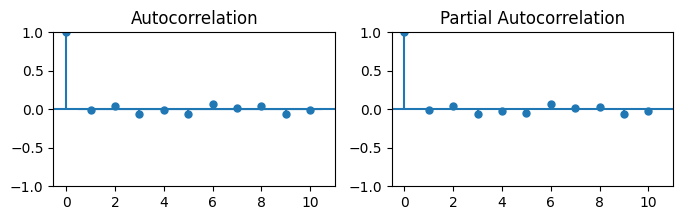

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2))
plot_acf(train_set, lags=10, ax=ax1)
plot_pacf(train_set, lags=10, ax=ax2)
plt.show()

In [6]:
auto_arima_model = auto_arima(train_set, seasonal=True, m=10, trace=True)
print(auto_arima_model)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[10] intercept   : AIC=inf, Time=41.55 sec
 ARIMA(0,0,0)(0,0,0)[10] intercept   : AIC=380710.410, Time=0.26 sec
 ARIMA(1,0,0)(1,0,0)[10] intercept   : AIC=380708.565, Time=2.42 sec
 ARIMA(0,0,1)(0,0,1)[10] intercept   : AIC=380708.995, Time=2.43 sec
 ARIMA(0,0,0)(0,0,0)[10]             : AIC=383018.182, Time=0.13 sec
 ARIMA(1,0,0)(0,0,0)[10] intercept   : AIC=380710.937, Time=0.34 sec
 ARIMA(1,0,0)(2,0,0)[10] intercept   : AIC=380528.130, Time=8.35 sec
 ARIMA(1,0,0)(2,0,1)[10] intercept   : AIC=380524.914, Time=32.12 sec
 ARIMA(1,0,0)(1,0,1)[10] intercept   : AIC=380710.561, Time=6.96 sec
 ARIMA(1,0,0)(2,0,2)[10] intercept   : AIC=380519.130, Time=26.47 sec
 ARIMA(1,0,0)(1,0,2)[10] intercept   : AIC=380517.646, Time=12.99 sec
 ARIMA(1,0,0)(0,0,2)[10] intercept   : AIC=380516.019, Time=8.01 sec
 ARIMA(1,0,0)(0,0,1)[10] intercept   : AIC=380708.810, Time=3.01 sec
 ARIMA(0,0,0)(0,0,2)[10] intercept   : AIC=380514.054, Time=7.8

In [7]:
order = auto_arima_model.order
print(order)
seasonal_order = auto_arima_model.seasonal_order
print(seasonal_order)

(0, 0, 0)
(0, 0, 2, 10)


In [8]:
model = SARIMAX(train_set, order=order, seasonal_order=seasonal_order)
result = model.fit(disp=False)
print(result.summary())

                                   SARIMAX Results                                   
Dep. Variable:                        target   No. Observations:                24000
Model:             SARIMAX(0, 0, [1, 2], 10)   Log Likelihood             -191164.671
Date:                       Fri, 15 Dec 2023   AIC                         382335.343
Time:                               10:34:04   BIC                         382359.600
Sample:                                    0   HQIC                        382343.210
                                     - 24000                                         
Covariance Type:                         opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L10       0.0467      0.024      1.927      0.054      -0.001       0.094
ma.S.L20       0.1478      0.005     28.371      0.000       0.138       0.

In [9]:
#using ARIMA's residuals as input and train LSTM model

def create_data(data, time_steps=1):
    X, y = [], []
    data = data.values  # 转换为numpy数组
    for i in range(len(data) - time_steps):
        v = data[i:(i + time_steps)]
        X.append(v)
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# Get residuals from the SARIMA model on the train set
residuals = result.resid

X_train_lstm, y_train_lstm = create_data(residuals, time_steps=5)

# Reshape the input data to fit the LSTM model
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], 5, 1))  # time_steps=5

In [10]:
# create LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(5, 1)))  # time_steps=5
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mae')

# traning model
lstm_model.fit(X_train_lstm, y_train_lstm, epochs=10, batch_size=32, verbose=0)

In [13]:
# residuals on test set
"""
First perform SARIMA prediction on the test set, then calculate the difference between
 the actual value and the SARIMA prediction value as the residual
"""
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        # 找到当前时间步的历史记录，并将其添加到X中
        v = data[i:(i + time_steps)].flatten()
        X.append(v)
        # 将下一个时间步的值添加到y中
        y.append(data[i + time_steps])
    return np.array(X), np.array(y)

# predict SAMIMA model
sarima_predictions = result.get_forecast(steps=len(test_set))
sarima_predicted_mean = sarima_predictions.predicted_mean

# Ensure that the index predicted by SARIMA matches the index of the test set
sarima_predicted_mean.index = test_set.index

# calculate residuals on test set
residuals_test = test_set - sarima_predicted_mean

time_steps = 5
X_test_lstm, y_test_lstm = create_dataset(residuals_test.values, time_steps)
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], time_steps, 1))

# Residual prediction using LSTM model
lstm_predicted_residuals = lstm_model.predict(X_test_lstm)

188/188 [==============================] - 2s 10ms/step


In [14]:
# intercept the SARIMA prediction and test sets to match the shape of the LSTM predictions
sarima_predicted_mean_cut = sarima_predicted_mean.iloc[time_steps:]
test_set_cut = test_set.iloc[time_steps:]

# Ensure that the residuals predicted by the LSTM have the same shape as the truncated SARIMA predictions
lstm_predicted_residuals_cut = lstm_predicted_residuals.flatten()

# Prediction results combining SARIMA and LSTM
final_predictions = sarima_predicted_mean_cut + lstm_predicted_residuals_cut

# Evaluate final prediction performance
final_mae = mean_absolute_error(test_set_cut, final_predictions)
print(f"Final Mean Absolute Error (MAE): {final_mae}")

Final Mean Absolute Error (MAE): 212.869198306496
